<h1>Clinical Trials Data Analysis</h1>

<h2>Introduction</h2>

In this project, I will attempt to find the best hospital(s) to select 200 patients for clinical trial with the following conditions:

1. Aged 50 or above
2. Has a peak flow reading above 400 litres per minute (litres/min)
3. Has not had a flu case or flu shot in the last 6 months
4. Does not have an egg allergy
5. Does not have a history of respiratory conditions
6. Has a BMI (Body Mass Index) between 18-32 kg/m<sup>2</sup>
7. Non-smokers only

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The excel spreadsheet has been converted to a csv file so that it can be read easily
df = pd.read_csv("../data/hospitals_data.csv")

df.head()

,Unnamed: 0,SITEID,SUBJID,SEX,AGE,RACE,ALLERGY,MEDICAL,SMOKER,LAST_DOSE_FLU,BMI,PEAK_FLOW_1,PEAK_FLOW_2,PEAK_FLOW_3
0,0,Hospital A,GSK0001,M,79,MIXED,NaN,NaN,False,False,26,653,635,651
1,1,Hospital A,GSK0002,M,62,WHITE,NaN,NaN,False,True,35,458,449,438
2,2,Hospital A,GSK0003,M,71,ASIAN,NaN,NaN,True,True,21,370,350,352
3,3,Hospital A,GSK0004,M,73,BLACK,NaN,Heart,False,False,22,414,412,412
4,4,Hospital A,GSK0005,F,66,WHITE,NaN,NaN,False,True,29,632,651,627


<h2>Cleaning the data</h2>

There are a few things I need to do in order to clean the data.

1. Remove the `Unamed` row. This row is probably there due to it being an artefact when being converted from Excel to CSV format, so is unnecassery
2. Remove any duplicate rows
3. Remove any rows with invalid data
4. For the `AGE` row, change any data with obvious typos in it

In [2]:
pre_clean_count = len(df.index)     # Used with `post_clean_count` to show how many rows were dropped

# Removes the unamed column (which is first)
df.drop(columns=[df.columns[0]], axis=1, inplace=True)

# Removes any rows with *invalid* data
# In this case, I am going to deal with typos (such as in AGE column) later
# At first I will remove all items which *have* to be wrong  
valid_data = {
    "SITEID"        : (lambda site_id: pd.notna(site_id)),                                  # The SITEID cannot be N/A
    "SUBJID"        : (lambda subj_id: pd.notna(subj_id)),                                  # The SUBJID cannot be N/A
    "SEX"           : (lambda sex: pd.notna(sex)),                                          # The SEX cannot be N/A
    "AGE"           : (lambda age: str(age).strip('-').isnumeric()),                        # The AGE must be numeric (allowing negative values to clean)
    "RACE"          : (lambda race: race in ["MIXED", "WHITE", "ASIAN", "BLACK", "OTHER"]), # The RACE can only hvave the values which are in the list
    "ALLERGY"       : (lambda allergy: True),                                               # The ALLERGY can essentially be anything - N/A or a string
    "MEDICAL"       : (lambda medical: True),                                               # The MEDICAL can also be abything N/A or a string
    "SMOKER"        : (lambda smoker: type(smoker) == bool),                                # The smoker can only be a boolean (not N/A)
    "LAST_DOSE_FLU" : (lambda last_dose_flu: type(last_dose_flu) == bool),                  # The last flu shot can also only be a boolean
    "BMI"           : (lambda bmi: str(bmi).isnumeric()),                                   # The BMI can only be numeric as well
    "PEAK_FLOW_1"   : (lambda peak_flow: str(peak_flow).isnumeric()),                       # The PEAK_FLOW columns can also only be numeric
    "PEAK_FLOW_2"   : (lambda peak_flow: str(peak_flow).isnumeric()),                       # The PEAK_FLOW columns can also only be numeric
    "PEAK_FLOW_3"   : (lambda peak_flow: str(peak_flow).isnumeric()),                       # The PEAK_FLOW columns can also only be numeric     
}

# Removing all rows which cannot be valid by using the valid_data dictionary
invalid_rows = set()   # Set is used to avoid duplicate values
for column in df.columns:
    for index, field in df[column].items():
        if not valid_data[column](field): 
            invalid_rows.add(index)

print(invalid_rows)
df.drop(invalid_rows, inplace=True)

# Removes any duplicate rows
df.drop_duplicates(inplace=True)

post_clean_count = len(df.index)

print(f"There were originally {pre_clean_count} rows.\n \
    After removing invalid rows, there are {post_clean_count} rows.\n \
    In total, {pre_clean_count - post_clean_count} rows have been dropped.")

{1536, 2050, 1539, 2051, 1545, 532, 534, 2072, 2092, 1584, 1590, 2107, 2110, 576, 1603, 1605, 2126, 591, 1616, 1113, 2146, 1635, 612, 1650, 1150, 2174, 2178, 1677, 1167, 2193, 1687, 1692, 2207, 1697, 1193, 171, 2220, 1197, 1205, 2229, 2235, 2236, 1726, 1730, 708, 2254, 1744, 209, 2271, 1251, 1255, 1263, 1265, 245, 761, 1274, 768, 1796, 261, 1298, 278, 1819, 285, 1821, 1313, 1315, 807, 296, 1319, 304, 828, 1353, 340, 1876, 1879, 1888, 1890, 356, 367, 368, 1909, 1922, 1935, 404, 1429, 408, 1433, 411, 923, 413, 1441, 1957, 940, 1973, 438, 445, 1481, 973, 468, 470, 984, 1496, 2011, 991, 2018, 1517, 505, 1519, 2039, 1529}
There were originally 2284 rows.
     After removing invalid rows, there are 2121 rows.
     In total, 163 rows have been dropped.


Now it is time to clean the typos in the `AGE` column.
There are two main typos in the `AGE` column
The first typo is making the age negative, and the second typo is adding an extra 0.

In [3]:
pre_clean_age_minmax = min(df["AGE"]), max(df["AGE"])

for l in df["AGE"]:
    if l == 0:
        print(l)

df["AGE"] = df["AGE"].abs()     # Makes all the negative numbers positive
df["AGE"] = df["AGE"].map(lambda age: age // 10 if age > 150 else age)     # Removes the extra '0' from big numbers (e.g. 880 becomes 88)

print(df["AGE"])

post_clean_age_minmax = min(df["AGE"]), max(df["AGE"])

print(f"The minimum and maximum ages before cleaning were {pre_clean_age_minmax} respectively. \n \
    The minimum and maximum ages after cleaning were {post_clean_age_minmax} respectively.")

0       79
1       62
2       71
3       73
4       66
        ..
2275    77
2276    83
2277    63
2278    86
2279    58
Name: AGE, Length: 2121, dtype: int64
The minimum and maximum ages before cleaning were (-94, 880) respectively. 
     The minimum and maximum ages after cleaning were (28, 105) respectively.


<h2>Summary Statistics</h2>

In this section, I will represent some summary statistics for each site.
There are 5 different sites:
1. Hospital A
2. Hospital B
3. Hospital C
4. Hospital D
5. Hospital E


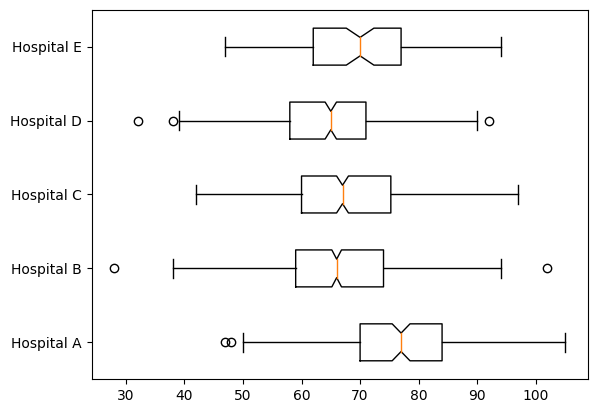

In [4]:
# Shows the age range in all sites as a box plot so it is easy to compare them

labels = df["SITEID"].unique()      # The labels will be all of the sites
data = []

# Appends age for each site to data
for site_id in df["SITEID"].unique():
    data.append([age for i, age in df["AGE"].items() if df["SITEID"][i] == site_id])
    
plt.boxplot(x=data, labels=labels, notch=True, vert=False)
plt.show()

From the above graph, it can be seen that Hospital A has the oldest patients on average, and Hospital B having the youngest patients on average. It can also be seen that most patients seem to be above 50 for all sites as well.

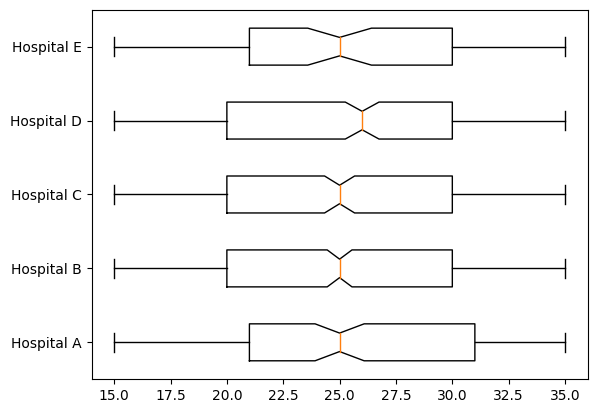

In [5]:
# We can make a similar set of box plots for the BMI

labels = df["SITEID"].unique()      # The labels will be all of the sites
data = []

# Appends age for each site to data
for site_id in df["SITEID"].unique():
    data.append([age for i, age in df["BMI"].items() if df["SITEID"][i] == site_id])
    
plt.boxplot(x=data, labels=labels, notch=True, vert=False)
plt.show()

The BMI is spread pretty evenly accross most hospitals, with the median being around 25.0 (with the exception of Hospital D which has a higher median BMI). 

I also wanted to give some summary stats on the average peak flow rate as well.

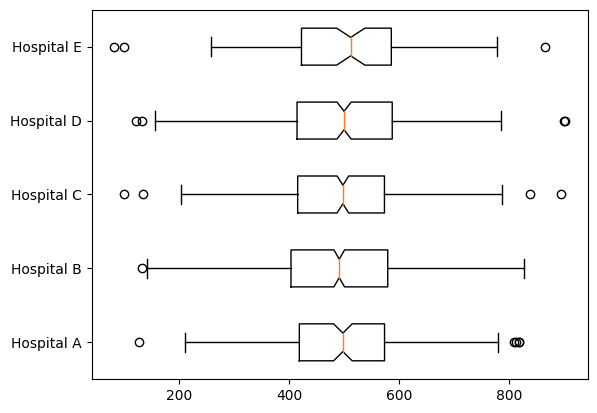

In [6]:
# To give summary statistics on the peak flow rate, the average peak flow rate needs to be found.
df["PEAK_FLOW_MEAN"] = (df["PEAK_FLOW_1"] + df["PEAK_FLOW_2"] + df["PEAK_FLOW_3"]) / 3

# A similar box plot can be made as done with the AGE and the BMI
labels = df["SITEID"].unique()      # The labels will be all of the sites
data = []

# Appends age for each site to data
for site_id in df["SITEID"].unique():
    data.append([age for i, age in df["PEAK_FLOW_MEAN"].items() if df["SITEID"][i] == site_id])
    
plt.boxplot(x=data, labels=labels, notch=True, vert=False)
plt.show()

All of the hospitals have a similar mean peak flow on average, but Hospital E has the smallest distribution.

<h2>Finding the Best Hospital</h2>

In this section, the number of patients who fit the inclusion/exclusion criteria will be found.

In [7]:
inclusion_exclusion_criteria = {
    "AGE"               : (lambda age: age >= 50),                          # Age must be more than 50
    "PEAK_FLOW_MEAN"    : (lambda peak_flow_mean: peak_flow_mean >= 400),   # The peak flow must be more than 400
    "LAST_DOSE_FLU"     : (lambda last_dose_flu: not last_dose_flu),        # Should not have had a flu shot in the last 6 months
    "ALLERGY"           : (lambda allergy: allergy != "Egg"),               # Should not have an egg allergy
    "MEDICAL"           : (lambda medical: medical != "Respiratory"),       # Should not have a history of respiratory conditions
    "BMI"               : (lambda bmi: 18 <= bmi <= 32),                    # Should have a BMI between 18-32
    "SMOKER"            : (lambda smoker: not smoker),                      # Should not be a smoker
}

# Stores the indexes of the patients who can't participate in the clinical trials 
invalid_patients = set()
for index, row in df.iterrows():
    #print(row)
    patient_valid = True    # Can the patient take part in the clinical trial? 
    for column, field in row.items():
        if not inclusion_exclusion_criteria.get(column, lambda _: True)(field):  # Checks the criteria to see if the field is valid or not
            patient_valid = False
    if not patient_valid:
        invalid_patients.add(index)
    
clinical_trial_patients_df = df.drop(invalid_patients)

print(f"There are {len(clinical_trial_patients_df.index)} patients who can do the clinical trial")

clinical_trial_patients_df.head()
    

There are 461 patients who can do the clinical tr


,SITEID,SUBJID,SEX,AGE,RACE,ALLERGY,MEDICAL,SMOKER,LAST_DOSE_FLU,BMI,PEAK_FLOW_1,PEAK_FLOW_2,PEAK_FLOW_3,PEAK_FLOW_MEAN
0,Hospital A,GSK0001,M,79,MIXED,NaN,NaN,False,False,26,653,635,651,646.333333
3,Hospital A,GSK0004,M,73,BLACK,NaN,Heart,False,False,22,414,412,412,412.666667
7,Hospital A,GSK0008,M,69,MIXED,NaN,NaN,False,False,30,827,810,818,818.333333
8,Hospital A,GSK0009,F,91,BLACK,NaN,NaN,False,False,21,476,469,473,472.666667
9,Hospital A,GSK0010,F,81,BLACK,NaN,Other,False,False,26,455,440,448,447.666667


In [15]:
site_ids = df["SITEID"].unique()

patients_per_site = {
    site_id : (valid_patients := 
            len(clinical_trial_patients_df[clinical_trial_patients_df["SITEID"] == site_id].index))  
        for site_id in site_ids
}

for site_id in patients_per_site:
    print(f"{site_id} has {patients_per_site[site_id]} valid patients who can participate in the clinical trials.")

Hospital A has 54 valid patients who can participate in the clinical trials.
Hospital B has 154 valid patients who can participate in the clinical trials.
Hospital C has 118 valid patients who can participate in the clinical trials.
Hospital D has 101 valid patients who can participate in the clinical trials.
Hospital E has 26 valid patients who can participate in the clinical trials.


From this, we can see that the sites with the most patients who can participate in the clinical trials are Hospitals B and C, so in order to reach the quota of at least 200 patients to take part in the trial, I would choose Hosptal B and Hospital C which would give a total of 272 possible patients to take part in the trial.